#Import Library

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

import tensorflow.keras
from keras.layers import Dense
from keras.models import Sequential
import numpy as np

from keras import optimizers
from tensorflow.keras import regularizers
from keras import regularizers
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D
import random

import matplotlib.pyplot as plt

from skimage.io import concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split, KFold

from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Load Data

No. of images =  130


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/130 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


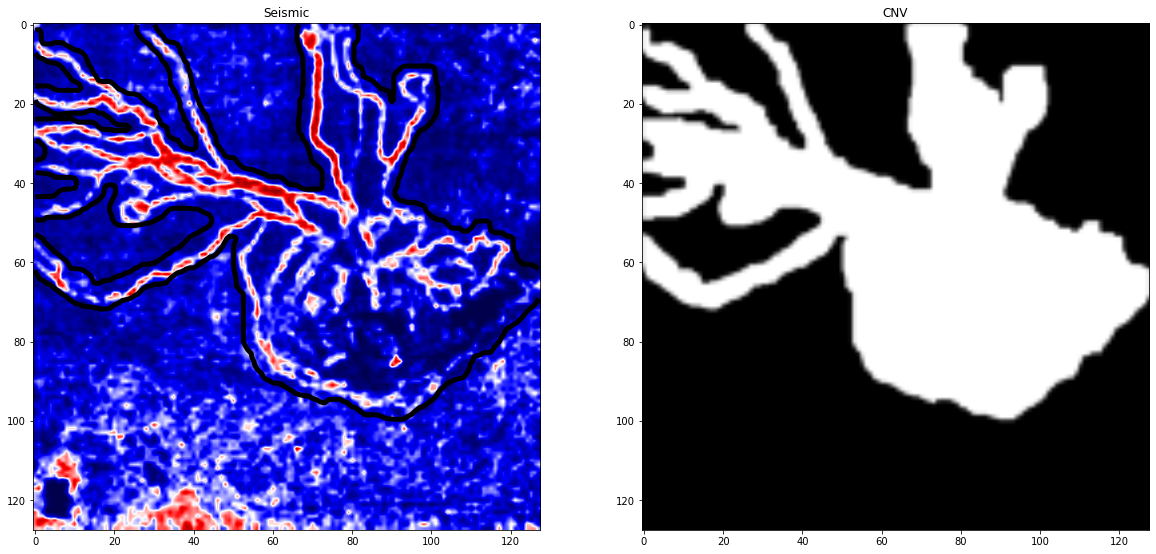

In [ ]:
# Set some parameters
#BATCH_SIZE = 5
im_width = 128
im_height = 128
border = 5

images='/content/drive/MyDrive/cnvdata/segmentationData/outer retina/'
#Test_images='/content/drive/My Drive/Colab Notebooks/salt/cnv_test/images/'
#weights_path='/content/drive/MyDrive/cnvdata/lung.h5/'
ids = next(os.walk(images))[2] # list of names all images in the given path
#for (root,dirs,files) in os.walk('tgs-salt-identification-challenge', topdown=True): 
print("No. of images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img(images+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    masks='/content/drive/MyDrive/cnvdata/segmentationData/masks/'
    mask = img_to_array(load_img(masks+id_,grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    #### Normalized data
    X[n] = x_img/255.0
    y[n] = mask/255.0
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # cnv indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if cnv
    # draw a boundary(contour) in the original image separating cnv and non-cnv areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('CNV')

print('Done!')

In [ ]:
seed=42
def get_train_test_augmented(X_data=X_train, Y_data=y_train, validation_split=0.25, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
 # Image data generator distortion options
    data_gen_args = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         samplewise_center=True,
                         samplewise_std_normalization=True,
                         rotation_range=90,
                         width_shift_range=0.05,
                         height_shift_range=0,
                         zoom_range=0.4,
                         shear_range=0.04,
                         fill_mode='reflect',
                         vertical_flip=False,
                         horizontal_flip=True)  #use 'constant'??

# Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

 # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

Data Augmentation

In [ ]:
seed=42
def get_train_test_augmented(X_data=X_train, Y_data=y_train, validation_split=0.1, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
 # Image data generator distortion options
    data_gen_args = dict(rotation_range=10,
                         width_shift_range=0.05,
                         height_shift_range=0.05,
                         shear_range=0.4,
                         zoom_range=0.4,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??

# Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)

 # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

#Loss Function


In [ ]:
def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


#Build Model

In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [ ]:
from tensorflow import keras

def ResUNet():
    f = [8, 16, 32, 68, 101]
    inputs = keras.layers.Input((im_width, im_height, 1))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

Model1

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    

    return x
def get_unet(input_img, n_filters = 16, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    #Bottle necK
    ## 
    c5 = conv2d_block(p4, n_filters = n_filters * 32, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    #fully connected 
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Model2


*   Pre_Train with Weight



In [ ]:
from keras.regularizers import l1,l2

input_layer = Input(shape=X_train.shape[1:])
c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(input_layer)
l = MaxPool2D(strides=(2,2))(c1)

c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)
l = MaxPool2D(strides=(2,2))(c2)

c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)
l = MaxPool2D(strides=(2,2))(c3)

c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)

l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)
l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same',kernel_regularizer=l2(1e-5))(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
l = Dropout(0.5)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)

model = Model(input_layer, output_layer)
weights_path='/content/drive/MyDrive/cnvdata/lung.h5'
model.load_weights(weights_path)
for layer in model.layers[:13]:
   layer.trainable = False
model.summary()

In [ ]:
for (train_index, test_index) in enumerate(kf.split(x_train,ytrain)):
  print("**********************")
  print("****FOLD NUM",j)
  X_train, X_test = x_train[train_index,:],x_train[test_index,:]
  y_train, y_test = ytrain[train_index], ytrain[test_index]
  set_seed(42)

NameError: ignored

##Train


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 128, 128, 16  64         ['conv2d_20[0][0]']              
 ormalization)                  )                                                           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


195/195 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8632 - dice_coef: 0.6904 - precision_m: 0.6995 - recall_m: 0.9230 - f1_m: 0.7889
Epoch 1: val_loss improved from inf to 0.79768, saving model to model-tgs-salt.h5
195/195 [==============================] - 32s 91ms/step - loss: 0.3006 - accuracy: 0.8632 - dice_coef: 0.6904 - precision_m: 0.6995 - recall_m: 0.9230 - f1_m: 0.7889 - val_loss: 0.7977 - val_accuracy: 0.8534 - val_dice_coef: 0.2023 - val_precision_m: 0.9571 - val_recall_m: 0.1129 - val_f1_m: 0.2020 - lr: 0.0010
Epoch 2/30
195/195 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.8906 - dice_coef: 0.8274 - precision_m: 0.8209 - recall_m: 0.9066 - f1_m: 0.8573
Epoch 2: val_loss improved from 0.79768 to 0.13907, saving model to model-tgs-salt.h5
195/195 [==============================] - 17s 86ms/step - loss: 0.1677 - accuracy: 0.8906 - dice_coef: 0.8274 - precision_m: 0.8209 - recall_m: 0.9066 - f1_m: 0.8573 - val_loss: 0.1391

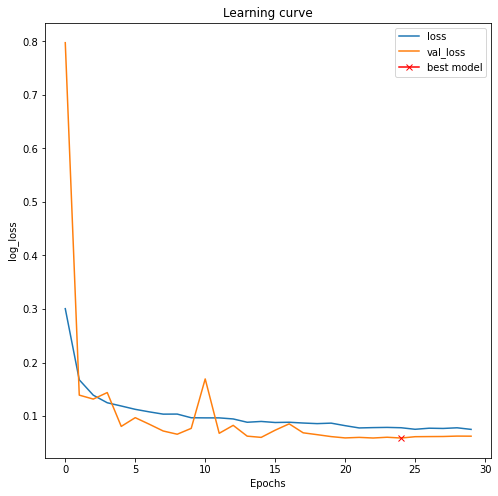

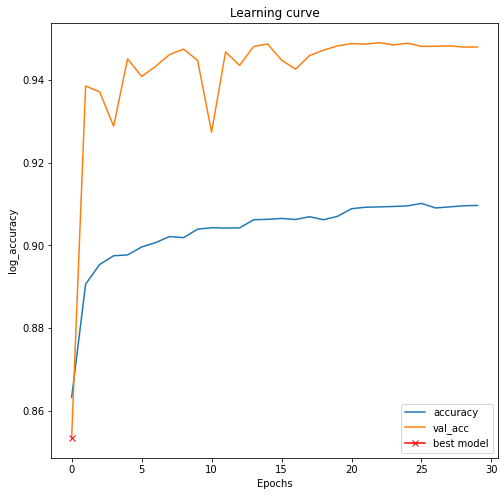

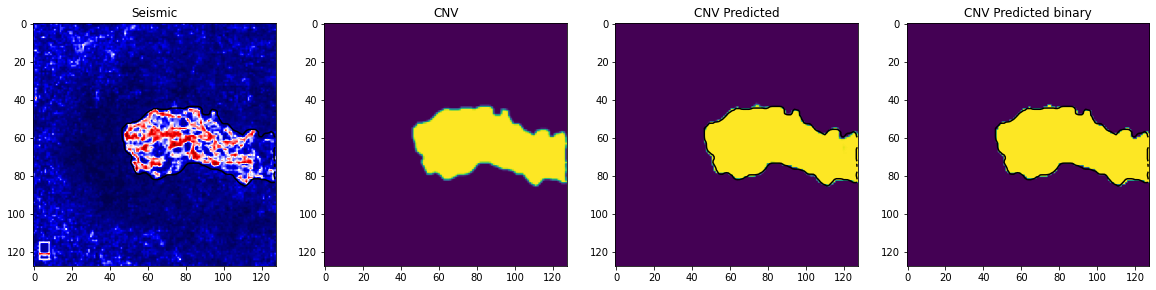

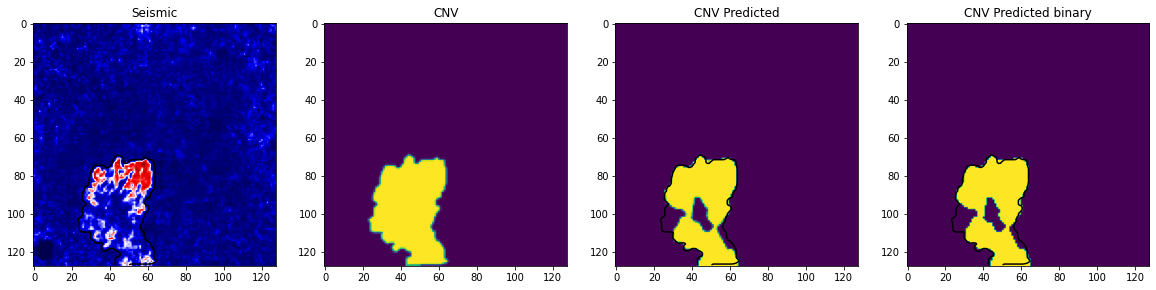

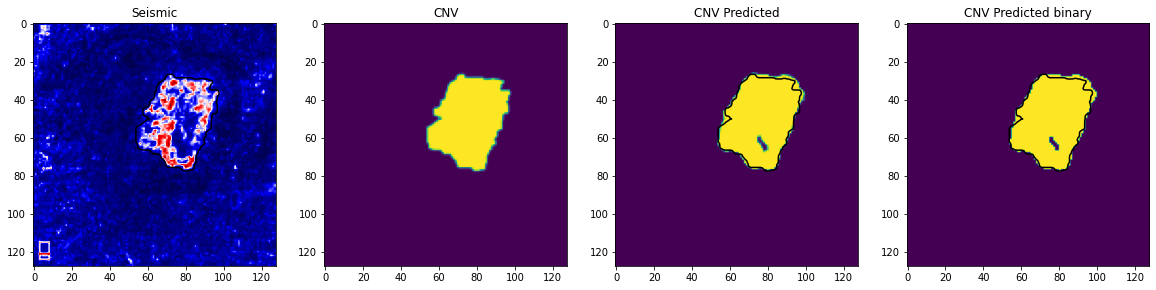

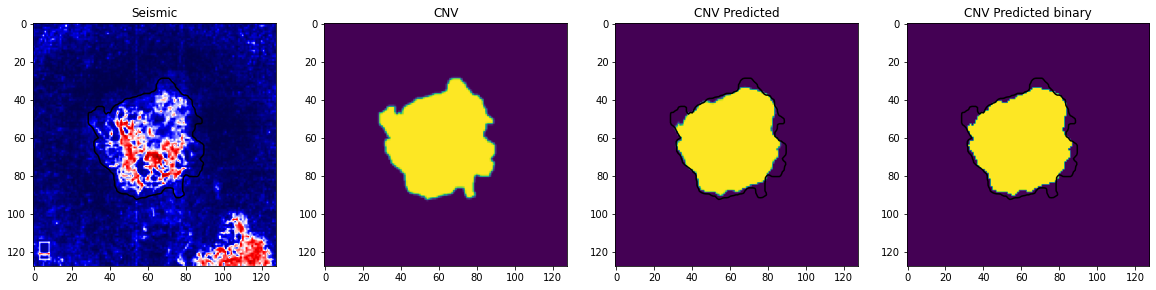

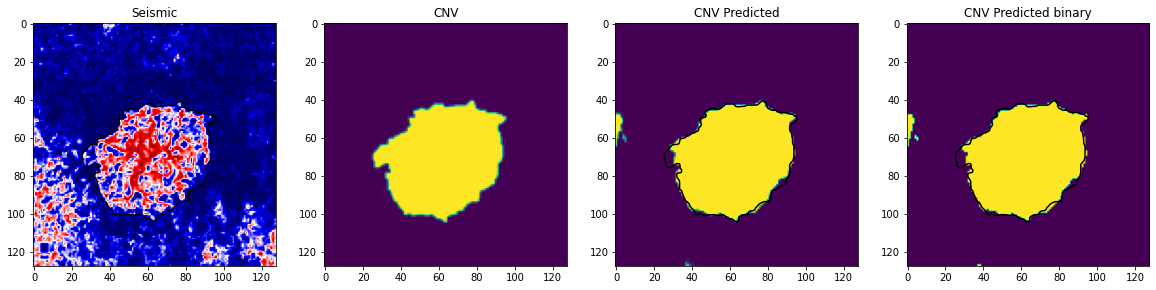

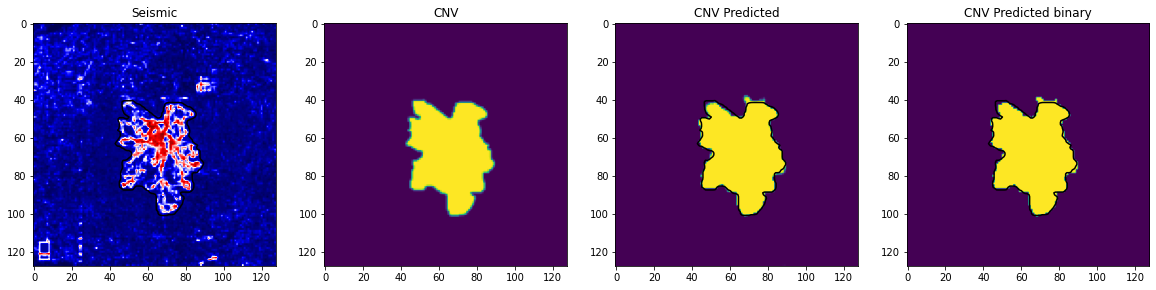

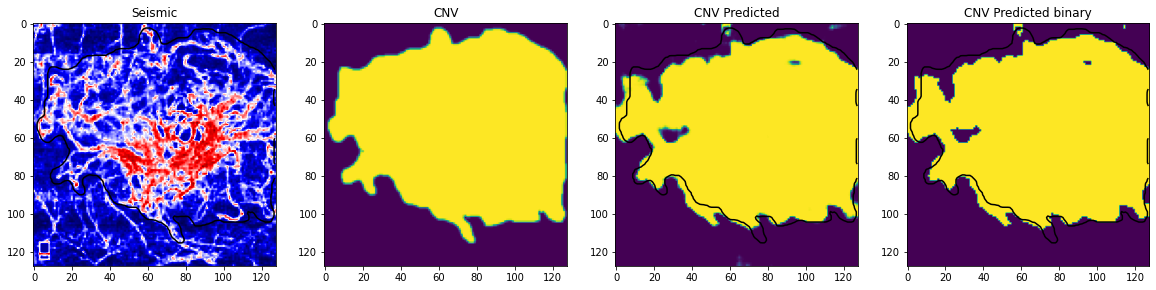

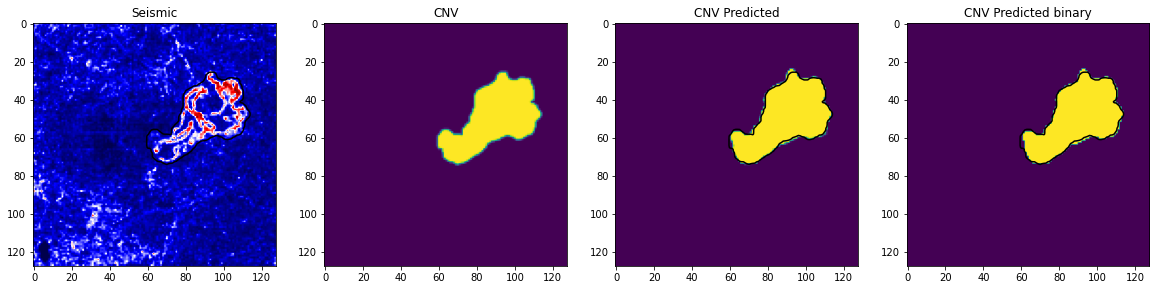

In [ ]:
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from keras.backend import minimum, maximum
def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

input_img = Input((im_height, im_width, 1), name='img')

def my_loss(y_true, y_pred):
  layer_names = [layer.name for layer in model.layers]
  for l in layer_names:
    if l==layer_names[-1]:
      value = TV_bin_loss(y_true, y_pred)
    else:
      value = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
  return value

#model = Model(input = input_img, output = conv10)
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.2, batchnorm=True)
#model=ResUNet()
#model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=[mean_iou()])
model.compile(optimizer=Adam(), loss=dice_loss, metrics=['accuracy',dice_coef, precision_m, recall_m, f1_m])
#model.compile(optimizer=Adam(), loss=jaccard_distance_loss, metrics=[dice_coef])
model.summary()

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

batch_size = 32
train_generator, test_generator = get_train_test_augmented(X_data=X_train, Y_data=y_train, validation_split=0.11, batch_size=batch_size)
results = model.fit_generator(train_generator, 
                     validation_data=test_generator, 
                     validation_steps=batch_size/2, 
                     steps_per_epoch=195, 
                     epochs=30, callbacks=callbacks)
#bs=32
#results = model.fit_generator(train_generator, steps_per_epoch=(len(X_train) // bs), epochs=70, callbacks=callbacks,
                              #validation_data=(X_valid, y_valid))
#results = model.fit_generator(train_generator,
                              #validation_data=val_generator, 
                              #validation_steps=10, 
                              #steps_per_epoch=180,
                              #epochs=20, callbacks=callbacks)
#results = model.fit(X_train, y_train, batch_size=20, epochs=60, callbacks=callbacks,\
                    #validation_data=(X_valid, y_valid))

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_acc")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_accuracy")
plt.legend();


# load the best model
#model.save('/content/drive/My Drive/savemymodel/my_model.h5')
model.load_weights('model-tgs-salt.h5')
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('CNV')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('CNV Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('CNV Predicted binary');

# Check if training data looks all right
for ix in range (4):
     plot_sample(X_train, y_train, preds_train, preds_train_t, ix)
     plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix)

#KFold

In [ ]:
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []


train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

EPOCHS = 30
BATCH_SIZE = 32

/content/drive/MyDrive/cnvdata/segmentationData/masks
for k, (train_index, test_index) in enumerate(kf.split(df)):
    train_data_frame = df.iloc[train_index]
    test_data_frame = df.iloc[test_index]
    
    train_gen = train_generator(train_data_frame, BATCH_SIZE,
                                None,
                                train_generator_args,
                                target_size=(height, width))

    test_gener = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))

    model = unet(input_size=(height,width, 3))
    model.compile(optimizer=Adam(lr=5e-6), loss=dice_coef_loss, \
                      metrics=[iou, dice_coef, sensitivity, specificity, 'binary_accuracy'])

    model_checkpoint = ModelCheckpoint(str(k+1) + '_unet_ner_seg.hdf5', 
                                       verbose=1, 
                                       save_best_only=True)

    history = model.fit_generator(train_gen,
                                  steps_per_epoch=len(train_data_frame) // BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  callbacks=[model_checkpoint],
                                  validation_data = test_gener,
                                  validation_steps=len(test_data_frame) // BATCH_SIZE)
    
    model = load_model(str(k+1) + '_unet_ner_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'sensitivity': sensitivity, 'specificity': specificity})
    
    test_gen = train_generator(test_data_frame, BATCH_SIZE,
                                None,
                                dict(),
                                target_size=(height, width))
    results = model.evaluate_generator(test_gen, steps=len(test_data_frame) // BATCH_SIZE)
    results = dict(zip(model.metrics_names,results))
    
    histories.append(history)
    accuracies.append(results['binary_accuracy'])
    losses.append(results['loss'])
    dicecoefs.append(results['dice_coef'])
    ious.append(results['iou'])
    
    break

SyntaxError: ignored

In [ ]:
acc_per_fold = []
loss_per_fold = []

num_folds = 5
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

NameError: ignored

#Load Test

In [ ]:
# Load TestData 
im_width = 128
im_height = 128
border = 5
num_class=2
Test_images='//content/drive/MyDrive/finaldata/image4/test/images/'
test_ids = next(os.walk(Test_images))[2]  # list of names all images in the given path
#for (root,dirs,files) in os.walk('tgs-salt-identification-challenge', topdown=True): 
print("No. of Test_images = ", len(test_ids))
X_test = np.zeros((len(test_ids), im_height, im_width, 1), dtype=np.float32)
label_test = np.zeros((len(test_ids), im_height, im_width, 1), dtype=np.float32)
sizes_test = []
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    # Load images
    img2 = load_img(Test_images+id_, grayscale=True)
    x_img2 = img_to_array(img2)
    x_img2 = resize(x_img2, (128, 128, 1), mode = 'constant', preserve_range = True)
    X_test[n,:,:,:]=x_img2
    X_test[n] = x_img2/255.0
    #Load masks
    masks2='//content/drive/MyDrive/finaldata/image4/test/masks/'
    mask2 = img_to_array(load_img(masks2+id_ ,grayscale=True))
    mask2 = resize(mask2, (128, 128, 1), mode = 'constant', preserve_range = True)
    #msk[n,:,:,:]=mask2
    label_test[n]=np.round(mask2/255)
    # Save images
    #### Normalized data
    
    label_test[n] = mask2/255.0 
    #for i in range(0, num_class):
     #         label_test[n,:,:,i] = np.where(mask2 ==i,1,0)

No. of Test_images =  22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
# Load TestData 
from skimage.io import imread

im_width = 128
im_height = 128
border = 5
num_class=2
Test_images='/content/drive/MyDrive/finaldata/image1/test/images/'
test_ids = next(os.walk(Test_images))[2]  # list of names all images in the given path
#for (root,dirs,files) in os.walk('tgs-salt-identification-challenge', topdown=True): 
print("No. of Test_images = ", len(test_ids))
X_test = np.zeros((len(test_ids), im_height, im_width, 1), dtype=np.float32)
label_test = np.zeros((len(test_ids), im_height, im_width, num_class), dtype=np.float32)
sizes_test = []
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    # Load images
    img2 = load_img(Test_images+id_)
    x_img2 = img_to_array(img2)
    x_img2 = resize(x_img2, (128, 128, 1), mode = 'constant', preserve_range = True)
    X_test[n,:,:] = x_img2/255.0
    #Load masks
    masks2='/content/drive/MyDrive/finaldata/image1/test/masks/'
    mask2 = imread(masks2+id_)
    mask2 = resize(mask2, (128, 128 ,1), mode = 'constant', preserve_range = True)
    
    label_test[n,:,:,:]=mask2/255.0
    #### Normalized data
    
    #label_test[n] = mask2/255.0 
    for i in range(0, num_class):
      label_test[n,:,:,i] = np.where(mask2==i,0,1)[0]

In [ ]:
dicecnv=dice_coef(y_pred_test,label_test)
print('udic=',dicecnv)

udic= tf.Tensor(0.87450236, shape=(), dtype=float32)


In [ ]:
#label_test[n] = mask2/255.0 
for i in range(0, num_class):
  label_test[n,:,:] = np.where(mask2==i,1,0)[0]

In [ ]:
def dice_coef(y_pred, y_true):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)


def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)



In [ ]:
def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)


dicecnv=dice_coef_binary(y_pred_test,label_test)
print('unet=',dicecnv)

F1 Score

In [ ]:
#Predict
#model.load_weights('cnv.h5')
model.load_weights('model-tgs-salt.h5')
y_pred_test=model.predict(X_test)


In [ ]:
def generalized_dice_loss_w(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = np.zeros((Ncl,))
    for l in range(0,Ncl): w[l] = np.sum( np.asarray(y_true[:,:,:,0]==1,np.int32) )
    w = 1/(w**2+0.00001)

    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)
    
    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)
    
    gen_dice_coef = numerator/denominator
    
    return 1-2*gen_dice_coef

dicecnv1=generalized_dice_loss_w(label_test,y_pred_test)

print('unet=',dicecnv1)

unet= tf.Tensor(0.16679156, shape=(), dtype=float32)


In [ ]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2,3))
    den = num + alpha*K.sum(p0*g1,(0,1,2,3)) + beta*K.sum(p1*g0,(0,1,2,3))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T
dicecnv=tversky_loss(y_pred_test,label_test)

print('unet=',dicecnv)

unet= tf.Tensor(0.11675215, shape=(), dtype=float32)


In [ ]:
def generalized_dice_coefff(y_true, y_pred):
    n_el = 1
    for dim in y_train.shape: 
        n_el *= int(dim)
        n_cl = y_train.shape[-1]
        w = K.zeros(shape=(n_cl,))
        w = (K.sum(y_true, axis=(0,1,2)))/(n_el)
        w = 1/(w**2+0.000001)
        numerator = y_true*y_pred
        numerator = w*K.sum(numerator,(0,1,2))
        numerator = K.sum(numerator)
        denominator = y_true+y_pred
        denominator = w*K.sum(denominator,(0,1,2))
        denominator = K.sum(denominator)
        return 2*numerator/denominator
dicecnv2=generalized_dice_coefff(y_pred_test,label_test)

print('unet=',dicecnv2)

unet= tf.Tensor(0.87450236, shape=(), dtype=float32)


In [ ]:
def generalized_dice_coeff(y_true, y_pred):
    Ncl = y_pred.shape[-1]
    w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0,1,2))
    w = 1/(w**2+0.000001)
    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1- generalized_dice_coeff(y_true, y_pred)

dicecnv3=generalized_dice_coeff(y_pred_test,label_test)

print('unet=',dicecnv3)

unet= tf.Tensor(0.87450236, shape=(), dtype=float32)


In [ ]:
def dice_coef2(y_true,y_pred,smooth=1):
  intersection=K.sum(y_true*y_pred,axis=[1,2,3])
  union=K.sum(y_true,axis=[1,2,3])+K.sum(y_pred,axis=[1,2,3])
  dice=K.mean((2.*intersection+smooth)/(union+smooth),axis=0)
  return dice
dice2=dice_coef2(y_pred_test,label_test)

print('un=',dice2)

un= tf.Tensor(0.8898949, shape=(), dtype=float32)


In [ ]:
def dice_coef_binary(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for 2 categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=2)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_binary_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef_binary(y_true, y_pred)


dice20=dice_coef_binary(y_pred_test,label_test)

print('unet=',dice20)    

In [ ]:
def dice_coef(y_pred, y_true):
  for tr in np.arange(0,1):
    y_pred_t = (y_pred[:,:,:,1] > tr).astype(np.uint8)
    y_true_f = np.array(y_true[:,:,:,1])
    y_pred_f = np.array(y_pred_t)
    intersection = np.sum(y_true_f * y_pred_f)
    print( 2*(intersection) / (np.sum(y_true_f) + np.sum(y_pred_f)))

dice=dice_coef(y_pred_test,label_test)

print('DSC_TV_unet=',dice)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

precision=precision_score(y_pred_test,label_test)
print('Precision: %5' % precision)

precision=recall_score(y_pred_test,label_test)
print('Recall: %5' % recall)

precision=f1_score(y_pred_test,label_test)
print('F1 score: %5' % f1)

NameError: ignored

In [ ]:
import numpy as np
label_test1=np.full((len(label_test),128,128,num_class),0)

for i in range(len(label_test)):
  m1=label_test[i,:,:]
  
  for ix in range(0,num_class):
    label_test1[i,:,:,ix] = np.where(m1==ix,1,0)
    

In [ ]:
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import average_precision_score
num_class=1


labels = []

########## For Unet Model
precision1 = dict()
recall1 = dict()
average_precision1 = dict()

for i in range(num_class):
  y_test_f=K.flatten(K.one_hot(K.cast(y_pred_test, 'uint8'), num_classes=1)[...,1:])
  preds_test_f=K.flatten(y_pred_test[...,1:])
  precision1[i], recall1[i], _ = precision_recall_curve(y_test_f,preds_test_f)
                                                       
  average_precision1[i] = average_precision_score(y_test_f,preds_test_f)
  
  

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#pre=precision_m(y_pred_test,label_test)

#print('unet=',pre)

#recall=recall_m(y_pred_test,label_test)

#print('unet=',recall)

#fscore=f1_m(y_pred_test,label_test)

#print('unet=',fscore)

In [ ]:
pre=precision_m(y_pred_test,label_test)

print('pre=',pre)

recall=recall_m(y_pred_test,label_test)

print('recall=',recall)

fscore=f1_m(y_pred_test,label_test)

print('f1=',fscore)

pre= tf.Tensor(0.85477006, shape=(), dtype=float32)
recall= tf.Tensor(0.8975855, shape=(), dtype=float32)
f1= tf.Tensor(0.87565464, shape=(), dtype=float32)


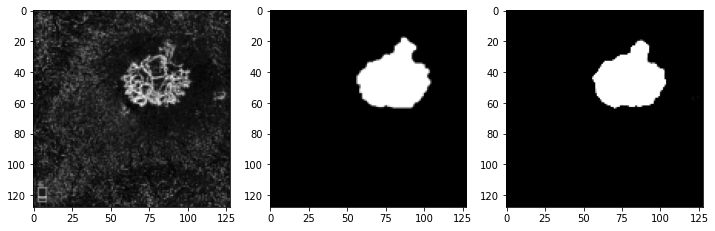

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,6))
#plt.axis('off')
ax[0].imshow(X_test[21,:,:,0], cmap='gray')
ax[1].imshow(label_test[21,:,:,0], cmap='gray')
ax[2].imshow(y_pred_test[21,:,:,0], cmap='gray')


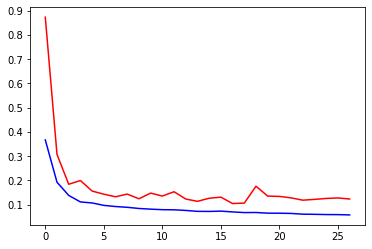

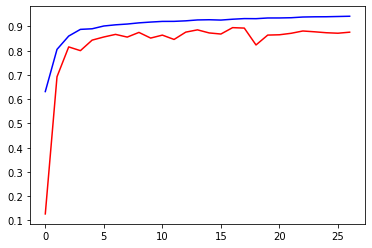

In [ ]:
plt.plot(results.history['loss'], label="loss", color='b')
plt.plot(results.history['val_loss'], label="val_loss", color='r')
plt.show()
plt.plot(results.history['dice_coef'],label="dice_coef", color='b')
plt.plot(results.history['val_dice_coef'], color='r')
plt.show()

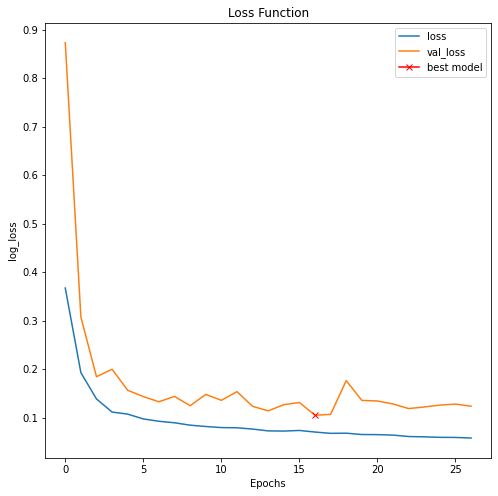

In [ ]:

plt.figure(figsize=(8, 8))
plt.title("Loss Function")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
 predicted_label = []
    for prediction in predictions[0]:
        if prediction[0] > 0.:
            predicted_label.append(1.)
        else:
            predicted_label.append(0.)
    print(f'Dice predicted to be kept: {predicted_label}')

In [ ]:
#results = model.evaluate(label_test, y_pred_test, batch_size=32)
#print("test loss, test acc:", results)

In [ ]:
import requests
import os
url='http://deepsense.ir:5001/api/upload_file'
path='/content/drive/MyDrive/cnvdata/score/'
for file in os.listdir(path):
  image_path=os.path.join(path,file)
  img={'image':open(image_path,'rb')}
  res=requests.post(url,files=img)
  print(res.text)
  print(res.status_code)

success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
success
200
succ